## Assignment - Decision Trees
---

> Kinshuk Vasisht (19)  
> M.Sc. Computer Science

### Prerequisites:

In [1]:
import math

import numpy
import pandas
import graphviz

from matplotlib import pyplot
from sklearn import metrics, model_selection

In [2]:
from google.colab import drive
drive.mount("/content/drive")

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import os
os.chdir("/content/drive/MyDrive/Datasets")

### Implementation of the Decision Tree Classifier:

#### Utility functions:

In [3]:
def cache_result(target, destination = None):
    """ Caches the return value of a wrapped function.

    ### Args:
        `target (str)`: Object attribute to store the cached result in.
        `destination (str, optional)`: Key to store the result in.
            Defaults to `None`, in which case the function name is used.
    """
    def cache_return_value(function):
        def _cache_return_value(self, *args, **kwargs):
            precomputed = getattr(self, target)
            old_value = precomputed.get(destination or function.__name__, None)
            if old_value is None:
                old_value = function(self, *args, **kwargs)
                precomputed[destination or function.__name__] = old_value
            return old_value
        return _cache_return_value
    return cache_return_value

#### Individual Node of the decision tree, for maintaining the nested structure:

In [4]:
class DTClassifierNode:
    """ Individual node of a decision tree. """

    criteria = [
        'gini_index',
        'entropy',
        'misclassification_error'
    ]
    operators = {
        '<': lambda x: lambda y: float(x) < float(y),
        '>': lambda x: lambda y: float(x) > float(y),
        '=': lambda x: lambda y: str(x) == str(y)
    }

    def __init__(self, classes, instances, responses):
        """ Creates a new node for a decision tree.

        Args:
            `classes (list[str])`: Class labels for the entire dataset
            `instances (pandas.DataFrame)`: Dataframe of features.
            `responses (pandas.Series)`: Series of target values.
        """
        self.instances = instances
        self.responses = responses
        self.labels    = classes

        self.attribute   = None
        self.operator    = None
        self.children    = None
        self.precomputed = {}

        self.invalidate()

    @property
    @cache_result('precomputed')
    def majority_class(self):
        """ Returns the majority class at the node. """
        return max(self._classes, key = self._classes.get)

    def invalidate(self):
        """
            Invalidate computed information such as majority class
            and value for impurity metrics.
        """
        self._classes = { label: 0 for label in self.labels }
        for value in self.responses: self._classes[value] += 1
        self._instance_count = len(self.responses)
        for value in self.precomputed: self.precomputed[value] = None

    @property
    @cache_result('precomputed')
    def gini_index(self):
        """ Gini Index: 1 - sum(p(i|m) ^ 2) """
        if self._instance_count == 0: return 0.0
        return 1.0 - sum(
            (class_instance_count / self._instance_count) ** 2
            for class_instance_count in self._classes.values()
        )

    @property
    @cache_result('precomputed')
    def entropy(self):
        """ Entropy: - sum(p(i|m) * log2(p(i|m))) """
        if self._instance_count == 0: return 0.0
        class_probabilities = (
            (class_instance_count / self._instance_count)
            for class_instance_count in self._classes.values()
        )
        return - sum(
            p * (math.log2(p) if p > 0 else 0.0)
            for p in class_probabilities
        )

    @property
    @cache_result('precomputed')
    def misclassification_error(self):
        """ Misclassification Error: 1 - max(p(i|m)) """
        if self._instance_count == 0: return 0.0
        return 1.0 - max(
            (class_instance_count / self._instance_count)
            for class_instance_count in self._classes.values()
        )

    def gain(self, criterion):
        """
            Computes the gain for a node set, defined as the difference
            between the impurity measure of the parent and the weighted
            impurity measure of the child nodes (weighted as per the share
            of the instances at the child nodes).
        """
        if self.children is not None:
            split_criterion = sum(
                (node._instance_count / self._instance_count)
                * node.measure(criterion)
                for node in self.children.values()
            )
            return self.measure(criterion) - split_criterion
        return 0.0

    @property
    @cache_result('precomputed')
    def split_entropy(self):
        """
            Computes the entropy of the split (aka split information),
            which gives a measure for evaulating the number of splits
            at a given node. This information helps compare purer but
            sparser nodes against slightly impurer but denser nodes.
        """
        if self.children is not None:
            branch_probabilities = (
                (node._instance_count / self._instance_count)
                for node in self.children.values()
            )
            entropy = - sum(
                p * (math.log2(p) if p > 0 else 0.0)
                for p in branch_probabilities
            )
            return entropy if entropy > 0 else math.inf
        return math.inf

    def gain_ratio(self, criterion):
        """
            Computes the gain ratio at a given node, which judges gain weighted
            with the inverse of the split information. This helps prefer denser
            and reduced number of splits compared to large number of splits into 
            sparse nodes (and may improve generalization ability of the tree).
        """
        return self.gain(criterion) / self.split_entropy

    def measure(self, criterion):
        """
            Returns the value of the requested
            impurity measure, by label.
        """
        return getattr(self, criterion, None)

    def predict(self, instance):
        """
            Predict the class for a given instance,
            based on the results of learnt information.
        """
        if self.children is None:
            # Return the majority class at the leaf node.
            return self.majority_class
        else:
            instance_value = instance[self.attribute]
            attr_fx = self.operators[self.operator](instance_value)
            for attr_value in self.children:
                if attr_value[0] == '!':
                    if not (attr_fx(type(instance_value)(attr_value[1:]))):
                        return self.children[attr_value].predict(instance)
                elif attr_fx(type(instance_value)(attr_value)):
                    return self.children[attr_value].predict(instance)
            # return self._majority_class
            raise ValueError(
                "predict(): branches exhausted for given instance"
            )


#### Decision Tree Classifier:

In [34]:
class DecisionTreeClassifier:
    """
        Classifier based on Decision Tree,
        trainable via different impurity measures.
    """
    def __init__(
        self, criterion, max_depth=None,
        threshold=0.0, use_gain_ratio=False
    ):
        """ Creates a new Decision Tree Classifier

        Args:
            `criterion (str)`: The criterion to use to
                determine the best split.
            `max_depth (int, optional)`: Maximum depth
                to recurse. Defaults to None.
            `threshold (float, optional)`: Threshold
                (maximum) for the impurity value (terminates
                    when impurity is below the threshold). Defaults to 0.0.
            `use_gain_ratio (bool, optional)`: If true,
                uses gain ratio instead of gain to determine splits.
                    Defaults to False.
        """
        self.root = None
        self.criterion = criterion
        self.max_depth = max_depth
        self.threshold = threshold
        self.use_gain_ratio = use_gain_ratio

    def fit(self, instances, responses):
        """ Fits a decision tree over given instances and responses. """
        classes = responses.unique()
        self.root = DTClassifierNode(classes, instances, responses)
        self._generate_tree(self.root, classes)

    def _generate_tree(self, node, classes, depth = 0):
        """
            Internal method: recursively generates the tree
            rooted at a given node based on the best splits.
        """
        # While the stopping criteria are not met ...
        if node.measure(self.criterion) > self.threshold and \
            (self.max_depth is None or depth < self.max_depth):
            # ... determine the best split, and generate
            # children for the current node ...
            self.split_node(node, classes)
            # ... recursively apply tree generation over children nodes, if any.
            if node.children is not None:
                next_depth = depth + 1 if depth is not None else None
                for i, child_node in enumerate(node.children.values()):
                    self._generate_tree( child_node, classes, next_depth )
        return node

    @staticmethod
    def possibly_discrete(node, attribute):
        """ Utility function to test whether an attribute is discrete. """
        return attribute.lower().endswith("id") or \
            attribute.lower().endswith("year")

    def split_node(self, node, classes):
        highest_gain = 0.0
        best_children = None
        best_decision = [ None, None ]
        all_gains = {}

        for attribute in node.instances.columns:
            attribute_column = node.instances[attribute]

            # Continuous Attribute
            if attribute_column.dtype.kind in 'uifc' and \
                not self.possibly_discrete(node, attribute):
                # Reappend class labels
                node.instances.insert(0, "labels", node.responses)
                data = node.instances.sort_values(by = [ attribute ])
                _responses, _instances = data.iloc[:, 0], data.iloc[:, 1:]
                node.instances.drop("labels", axis=1, inplace=True)
                node.instances = _instances

                split_point = None

                mid_value       = _instances[attribute].iloc[0] - 1
                instance_filter = _instances[attribute] < mid_value
                left  = DTClassifierNode(
                    classes,
                    _instances[instance_filter].copy(),
                    _responses[instance_filter].copy()
                )
                right = DTClassifierNode(
                    classes, _instances, _responses
                )
                node.children = { 0: left, 1: right }

                gains = {}
                best_current_gain = 0.0
                previous_value = _instances[attribute].iloc[0]
                for value in _instances[attribute].iloc[1:]:
                    # Shift tuples across nodes ...
                    mid_value = ( previous_value + value ) / 2
                    # ... add one to the left ...
                    right_inst = right.instances.iloc[0]
                    right_resp = right.responses.iloc[0]
                    left.instances.loc[len(left.instances)] = right_inst
                    left.responses.loc[len(left.responses)] = right_resp
                    # ... remove one from the right ...
                    right.instances = right.instances.iloc[1:, :]
                    right.responses = right.responses.iloc[1:]
                    # ... and invalidate cached information.
                    left.invalidate(); right.invalidate()

                    if self.use_gain_ratio:
                        current_gain = node.gain_ratio(self.criterion)
                    else:
                        current_gain = node.gain(self.criterion)

                    gains[mid_value] = current_gain
                    if current_gain > best_current_gain:
                        best_current_gain = current_gain
                        split_point = mid_value
                    previous_value = value

                all_gains[attribute] = gains
                if best_current_gain > highest_gain:
                    instance_filter = _instances[attribute] < split_point
                    best_children = {
                        f"{round(split_point, 4)}": DTClassifierNode(
                            classes, _instances[instance_filter],
                            _responses[instance_filter]
                        ),
                        f"!{round(split_point, 4)}": DTClassifierNode(
                            classes, _instances[~instance_filter],
                            _responses[~instance_filter]
                        ),
                    }
                    best_decision = [ attribute, '<' ]
                    highest_gain = best_current_gain

            # Discrete Attribute
            else:
                values = attribute_column.unique()
                children = {}

                for value in values:
                    instance_filter = attribute_column == value
                    subinstances = node.instances[instance_filter]
                    subresponses = node.responses[instance_filter]
                    children[value] = DTClassifierNode(
                        classes, subinstances, subresponses
                    )
                node.children = children

                if self.use_gain_ratio:
                    current_gain = node.gain_ratio(self.criterion)
                else:
                    current_gain = node.gain(self.criterion)

                all_gains[attribute] = current_gain
                if current_gain > highest_gain:
                    best_children = children
                    best_decision = [ attribute, '=' ]
                    highest_gain  = current_gain

        node.children = best_children
        node.attribute, node.operator = best_decision

        return all_gains

    def predict(self, instances):
        if self.root is None:
            raise ValueError(
                "predict(): tree not learnt, use fit() to learn the tree first"
            )
        return pandas.Series([
            self.root.predict(instance) for _, instance in instances.iterrows()
        ])

    def collect_measures(self, criterion = None, collect_as = 'direct', level = 2):
        """
            Collects the value of impurity measures (as direct,
            gain or gain_ratio) from the node structure into a linear list
        """
        if criterion is None:
            criterion = self.criterion
        measures = []
        if self.root is not None:
            queue = [ (0, self.root) ]
            while len(queue) > 0:
                clevel, node = queue.pop(0)
                if collect_as == "direct":
                    measures.append(node.measure(criterion))
                elif collect_as == "gain":
                    measures.append(node.gain(criterion))
                elif collect_as == "gain_ratio":
                    measures.append(node.gain_ratio(criterion))
                if node.children is not None and clevel < level:
                    queue.extend([ (clevel + 1, child) for child in node.children.values() ])
        return measures

### Training the classifier over the chosen dataset:

In [35]:
penguins  = pandas.read_csv("glass.csv")
penguins  = penguins.dropna()
instances = penguins.drop("Type", axis=1)
responses = penguins["Type"]

In [36]:
X_train, X_test, R_train, R_test = model_selection.train_test_split(
    instances, responses, random_state = 0, train_size = 0.7
)

In [37]:
tree = DecisionTreeClassifier(
    criterion = 'entropy', # Train via gain in entropy, aka information gain
    use_gain_ratio = False, max_depth = 10
)
tree.fit(X_train, R_train)

### Plotting the Decision Tree Structure:

In [38]:
def to_label(operator, value):
    if isinstance(value, str) and value[0] == '!':
        value = value[1:]
        if   operator == '=' : operator = '!='
        elif operator == '<' : operator = '>='
        elif operator == '>' : operator = '<='
        elif operator == '<=': operator = '>'
        elif operator == '>=': operator = '<'
    return f"{operator} {value}"

def export_graphviz(root = None):
    if isinstance(root, DecisionTreeClassifier): root = root.root
    if not isinstance(root, DTClassifierNode): return
    
    graph = graphviz.Digraph()
    graph.attr(fontsize='5', size="100,100")
    queue = []; index = 1
    if root is not None:
        values = ', '.join(str(i) for i in root._classes.values())
        if root.children is not None:
            label =  f"{{ {index}) {root.attribute} "
            label += f"| {{ values | [ { values } ] }}"
            label += " | { { " + ' | '.join(root.criteria) + " }"
            label += " | { " + ' | '.join(
                f"{round(root.measure(criterion), 4)}"
                for criterion in root.criteria
            ) + " }"
            label += " | { " + ' | '.join(
                f"{round(root.gain(criterion), 4)}"
                for criterion in root.criteria
            ) + " }"
            label += " | { " + ' | '.join(
                f"{round(root.gain_ratio(criterion), 4)}"
                for criterion in root.criteria
            ) + " } } }"
            graph.node(
                f"{index}", shape = 'record',
                style = 'rounded', label = label
            )
            queue.append((index, root)); index += 1
        else:
            label =  f"{{ {index}) {root.majority_class} "
            label += f"| {{ values | [ { values } ] }}"
            label += " | { { " + ' | '.join(root.criteria) + " }"
            label += " | { " + ' | '.join(
                f"{round(root.measure(criterion), 4)}"
                for criterion in root.criteria
            ) + " } } }"
            graph.node(
                f"{index}", shape = 'rectangle',
                label = f"{index}) {root.majority_class}{data}"
            )
            index += 1
    while len(queue) > 0:
        pindex, node = queue.pop(0)
        if node.children is not None:
            for attr_value, child_node in node.children.items():
                values = ', '.join(str(i) for i in child_node._classes.values())
                if child_node.children is not None:
                    label =  f"{{ {index}) {child_node.attribute} "
                    label += f"| {{ values | [ { values } ] }}"
                    label += " | { { " + ' | '.join(child_node.criteria) + " }"
                    label += " | { " + ' | '.join(
                        f"{round(child_node.measure(criterion), 4)}"
                        for criterion in child_node.criteria
                    ) + " }"
                    label += " | { " + ' | '.join(
                        f"{round(child_node.gain(criterion), 4)}"
                        for criterion in child_node.criteria
                    ) + " }"
                    label += " | { " + ' | '.join(
                        f"{round(child_node.gain_ratio(criterion), 4)}"
                        for criterion in child_node.criteria
                    ) + " } } }"
                    graph.node(
                        f"{index}", shape = 'record',
                        style = 'rounded', label = label
                    )
                    queue.append((index, child_node)); index += 1
                else:
                    label =  f"{{ {index}) {child_node.majority_class} "
                    label += f"| {{ values | [ { values } ] }}"
                    label += " | { { " + ' | '.join(child_node.criteria) + " }"
                    label += " | { " + ' | '.join(
                        f"{round(child_node.measure(criterion), 4)}"
                        for criterion in child_node.criteria
                    ) + " } } }"
                    graph.node( f"{index}", shape = 'record', label = label )
                    index += 1
                graph.edge(
                    f"{pindex}", f"{index-1}",
                    label = to_label(node.operator, attr_value)
                )
    return graphdot.render(format='png')

In [39]:
export_graphviz(tree)

NameError: name 'graphdot' is not defined

## Comparing values of impurity measures across nodes of first two levels:

([<matplotlib.axis.XTick at 0x7f2ec6c85c40>,
 [Text(0.22499999999999998, 0, '1'),
  Text(1.225, 0, '2'),
  Text(2.225, 0, '3'),
  Text(3.225, 0, '4'),
  Text(4.225, 0, '5'),
  Text(5.225, 0, '6'),
  Text(6.225, 0, '7')])

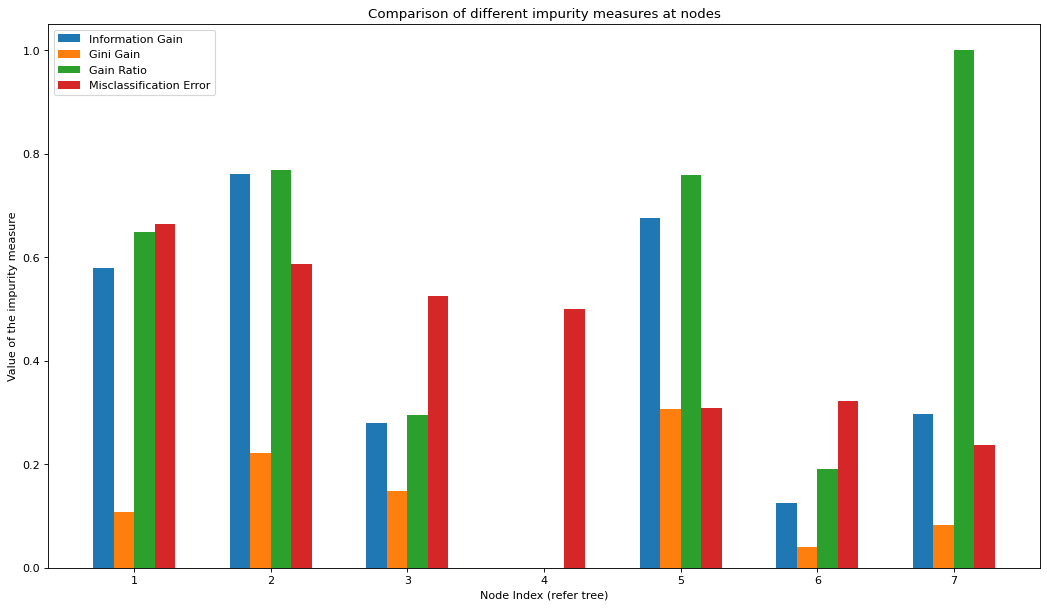

In [13]:
pyplot.figure(figsize = ( 16, 9 ), dpi = 80)

pyplot.title("Comparison of different impurity measures at nodes")
pyplot.xlabel("Node Index (refer tree)")
pyplot.ylabel("Value of the impurity measure")

info_gain  = tree.collect_measures('entropy'   , collect_as = 'gain', level = 2)
gini_gain  = tree.collect_measures('gini_index', collect_as = 'gain', level = 2)
gain_ratio = tree.collect_measures('entropy'   , collect_as = 'gain_ratio', level = 2)
mis_error  = tree.collect_measures('misclassification_error', level = 2)

x = numpy.arange(len(info_gain))
width = 0.15

pyplot.bar(x, info_gain, width, label = "Information Gain")
pyplot.bar(x+width, gini_gain, width, label = "Gini Gain")
pyplot.bar(x+width*2, gain_ratio, width, label = "Gain Ratio")
pyplot.bar(x+width*3, mis_error, width, label = "Misclassification Error")
pyplot.legend()
pyplot.xticks(x+width*1.5, x+1)

### Evaluating the classifier over unseen data:

In [26]:
print(metrics.classification_report(R_test, tree.predict(X_test)))

              precision    recall  f1-score   support

           1       0.50      0.71      0.59        21
           2       0.60      0.46      0.52        26
           3       0.00      0.00      0.00         7
           5       0.50      1.00      0.67         2
           6       0.50      1.00      0.67         2
           7       1.00      1.00      1.00         7

    accuracy                           0.58        65
   macro avg       0.52      0.70      0.57        65
weighted avg       0.54      0.58      0.55        65



/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
import itertools
combinations = itertools.product((False, True), DTClassifierNode.criteria)

for use_gain_ratio, criterion in combinations:
    tree_ = DecisionTreeClassifier(
        criterion = criterion,
        use_gain_ratio = use_gain_ratio, max_depth = 3
    )
    tree_.fit(X_train, R_train)
    print("Metrics for tree trained using splits based on gain",
          "ratio" if use_gain_ratio else "", "on", criterion, ":")
    print(metrics.classification_report(R_test, tree_.predict(X_test)))

Metrics for tree trained using splits based on gain  on gini_index :
              precision    recall  f1-score   support

           1       0.53      0.81      0.64        21
           2       0.70      0.54      0.61        26
           3       0.00      0.00      0.00         7
           5       0.50      1.00      0.67         2
           6       0.00      0.00      0.00         2
           7       0.78      1.00      0.88         7

    accuracy                           0.62        65
   macro avg       0.42      0.56      0.47        65
weighted avg       0.55      0.62      0.57        65



/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for tree trained using splits based on gain  on entropy :
              precision    recall  f1-score   support

           1       0.50      0.71      0.59        21
           2       0.60      0.46      0.52        26
           3       0.00      0.00      0.00         7
           5       0.50      1.00      0.67         2
           6       0.50      1.00      0.67         2
           7       1.00      1.00      1.00         7

    accuracy                           0.58        65
   macro avg       0.52      0.70      0.57        65
weighted avg       0.54      0.58      0.55        65



/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for tree trained using splits based on gain  on misclassification_error :
              precision    recall  f1-score   support

           1       0.48      0.71      0.58        21
           2       0.59      0.50      0.54        26
           3       0.00      0.00      0.00         7
           5       0.50      1.00      0.67         2
           6       0.00      0.00      0.00         2
           7       0.86      0.86      0.86         7

    accuracy                           0.55        65
   macro avg       0.41      0.51      0.44        65
weighted avg       0.50      0.55      0.52        65



/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for tree trained using splits based on gain ratio on gini_index :
              precision    recall  f1-score   support

           1       0.53      0.81      0.64        21
           2       0.70      0.54      0.61        26
           3       0.00      0.00      0.00         7
           5       0.50      1.00      0.67         2
           6       0.00      0.00      0.00         2
           7       0.78      1.00      0.88         7

    accuracy                           0.62        65
   macro avg       0.42      0.56      0.47        65
weighted avg       0.55      0.62      0.57        65



/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for tree trained using splits based on gain ratio on entropy :
              precision    recall  f1-score   support

           1       0.50      0.71      0.59        21
           2       0.60      0.46      0.52        26
           3       0.00      0.00      0.00         7
           5       0.50      1.00      0.67         2
           6       0.50      1.00      0.67         2
           7       1.00      1.00      1.00         7

    accuracy                           0.58        65
   macro avg       0.52      0.70      0.57        65
weighted avg       0.54      0.58      0.55        65



/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for tree trained using splits based on gain ratio on misclassification_error :
              precision    recall  f1-score   support

           1       0.48      0.71      0.58        21
           2       0.59      0.50      0.54        26
           3       0.00      0.00      0.00         7
           5       0.50      1.00      0.67         2
           6       0.00      0.00      0.00         2
           7       0.86      0.86      0.86         7

    accuracy                           0.55        65
   macro avg       0.41      0.51      0.44        65
weighted avg       0.50      0.55      0.52        65



/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/magnetium/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
tree_ = DecisionTreeClassifier(
    criterion = 'misclassification_error',
    use_gain_ratio = False, max_depth = 3
)
tree_.fit(X_train, R_train)

In [17]:
export_graphviz(tree_)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [18]:
def gain(tree, i):
    if tree.children_left[i] != -1:
        l = tree.children_left[i]
        r = tree.children_right[i]
        l_wt = tree.n_node_samples[l] / tree.n_node_samples[i]
        r_wt = tree.n_node_samples[r] / tree.n_node_samples[i]
        weighted_impurity = l_wt * tree.impurity[l] + r_wt * tree.impurity[r]
        return tree.impurity[i] - weighted_impurity
    return 0

def gini_gain(tree, i):
    gini = [
        1.0 - sum()
    ]
    if tree.children_left[i] != -1:
        l = tree.children_left[i]
        r = tree.children_right[i]
        l_wt = tree.n_node_samples[l] / tree.n_node_samples[i]
        r_wt = tree.n_node_samples[r] / tree.n_node_samples[i]
        weighted_impurity = l_wt * tree.impurity[l] + r_wt * gini[r]
        return gini[i] - weighted_impurity
    return 0

### Comparing Gains across different impurity measures:

In [19]:
tree1 = DecisionTreeClassifier(
    criterion = 'entropy',
    use_gain_ratio = False, max_depth = 3
)
tree2 = DecisionTreeClassifier(
    criterion = 'misclassification_error',
    use_gain_ratio = False, max_depth = 3
)

classes = responses.unique()
node = DTClassifierNode(classes, X_train, R_train)
tree1_gains = tree1.split_node(node, classes)
tree2_gains = tree2.split_node(node, classes)

In [20]:
pyplot.plot(
    [ *tree1_gains['flipper_length_mm'].keys() ],
    [ *tree1_gains['flipper_length_mm'].values() ],
    label = "Information Gain"
)
pyplot.plot(
    [ *tree2_gains['flipper_length_mm'].keys() ],
    [ *tree2_gains['flipper_length_mm'].values() ],
    label = "Misclassification Error Gain"
)
pyplot.title("Changes in Gain for different split points for flipper_length_mm")
pyplot.xlabel("Split point for flipper_length_mm")
pyplot.ylabel("Gain Value")
pyplot.legend()

KeyError: 'flipper_length_mm'

### Bibliography

- Dataset - Horst AM, Hill AP, Gorman KB (2020). palmerpenguins: Palmer Archipelago (Antarctica) penguin data. R package version 0.1.0. https://allisonhorst.github.io/palmerpenguins/ (Raw data as CSV for use in Python: https://github.com/mcnakhaee/palmerpenguins). doi: https://doi.org/10.5281/zenodo.3960218.